# Correlation analysis

## 1. Preprocessing

In [1]:
%%capture
%run Group_20_notebook.ipynb

### 1.2 Combine with fragmentation and polarization index

In [2]:
df_correlations = pd.merge(
    left=df.reset_index(),
    right=elections,
    how='left',
    left_on=['geo', 'year'],
    right_on=['geo', 'election_year']
).set_index(['geo', 'year']).sort_index()

# get rid of double column
df_correlations = df_correlations.drop(columns='election_date_x').rename(columns={'election_date_y': 'election_date'})

### 1.4 Checks

In [3]:
# Plausibility of values
vote_sums = df_correlations.groupby(['geo', 'year'])['vote_share_percent'].sum().reset_index()
vote_sums.columns = ['geo', 'year', 'total_vote_share']

# Check if any are far from 100
print(vote_sums[vote_sums['total_vote_share'] > 100])  

# if empty, no duplicates

Empty DataFrame
Columns: [geo, year, total_vote_share]
Index: []


# 2. Correlation analysis

## 2.1 Correlation heatmap
As a first step, we look at the correlations between relevant country characterstics and election outcomes, polarization and fragmentation. To avoid artificial underestimation of standard errors, we aggregate the yearly observations to inter-election intervals. Socioeconomic variables are aggregated by mean of the years leading up to an election. Election years are treated conditionally on the month of the election: If the election happened before July, most of that year did not happen and its variable values are used for the mean calculation of the next inter-election intervals. Otherwise, the election year is included in the current interval. 

In [4]:
vs_vars = [col for col in df_correlations.columns if col.startswith('vs_')]
df_correlations = df_correlations.reset_index() 
df_correlations = df_correlations.sort_values(['country', 'year'])

socioeco_vars = ['rel_immigration',
                 'gdp_per_cap',
                 'urban_population_pct',
                 'inflation_rate',
                 'unemployment_rate',
                 'Tertiary education',
                 'debt_to_gdp',
                 'dependency_ratio_15_64',
                 'median_age',
                 'wealth_top10_share']

# extract election year and month
df_correlations['election_year'] = pd.to_datetime(df_correlations['election_date']).dt.year
df_correlations['election_month'] = pd.to_datetime(df_correlations['election_date']).dt.month

# For each row, determine which election this year's data should predict
def assign_target_election(group):
    group = group.sort_values('year')
    
    # Get unique elections with their dates and months
    elections = (group[['election_date', 'election_year', 'election_month']]
                 .drop_duplicates()
                 .dropna() 
                 .sort_values('election_year')
                 .reset_index(drop=True))
    
    def find_target(year):
        for i, row in elections.iterrows():
            e_year = row['election_year']
            e_month = row['election_month']
            
            if year < e_year:
                # Year is before election year: belongs to this election
                return row['election_date']
            elif year == e_year and e_month >= 7:
                # Year equals election year AND election is in second half: belongs to this election
                return row['election_date']
        
        return None  # Year is after all elections
    
    group['target_election'] = group['year'].apply(find_target)
    return group

df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)

df_for_agg = df_correlations.dropna(subset=['target_election'])
df_averaged = df_for_agg.groupby(['country', 'target_election']).agg({
    'fragmentation_enp': 'first',
    'polarization_dalton': 'first',
    **{var: 'first' for var in vs_vars},
    **{var: 'mean' for var in socioeco_vars}
})

/var/folders/72/4mfr23zn6rl6yvskrt7mr9tc0000gn/T/ipykernel_54553/2869332271.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)


In [6]:
df_averaged.columns

Index(['fragmentation_enp', 'polarization_dalton', 'vs_AGR', 'vs_CHR',
       'vs_CON', 'vs_DIV', 'vs_ECO', 'vs_ETH', 'vs_LEF', 'vs_LIB', 'vs_NAT',
       'vs_SIP', 'vs_SOC', 'rel_immigration', 'gdp_per_cap',
       'urban_population_pct', 'inflation_rate', 'unemployment_rate',
       'Tertiary education', 'debt_to_gdp', 'dependency_ratio_15_64',
       'median_age', 'wealth_top10_share'],
      dtype='object')

The following code creates a correlation heatmap, which shows the correlations between party family vote shares, fragmentation and polarization in a country vs. all included economic and demographic variables. These results apply the entirety of the whole data set, i.e. across all years and countries. Thus, they should be interpreted as a crude overview. Positive correlations are depicted blue, negative correlations are red. Significant correlations are marked with asterisks.

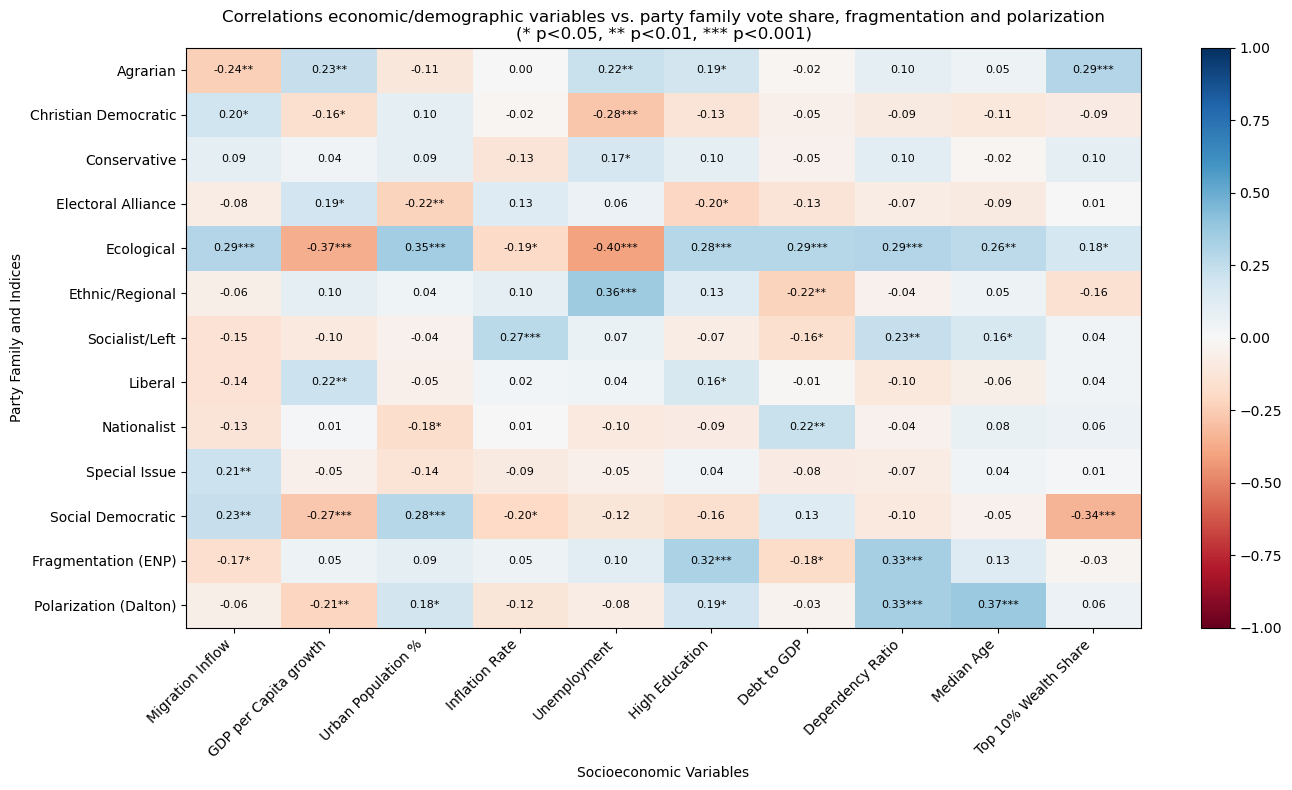

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Party family vote share columns
vs_cols = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

# calculate correlations and p-values
corr_matrix = []
pval_matrix = []

for vs_col in vs_cols:
    corr_row = []
    pval_row = []
    for socio_col in socioeco_vars:
        # Drop NaN values for both columns
        valid_data = df_averaged[[vs_col, socio_col]].dropna()
        if len(valid_data) > 2:
            corr, pval = stats.pearsonr(valid_data[vs_col], valid_data[socio_col])
        else:
            corr, pval = np.nan, np.nan
        corr_row.append(corr)
        pval_row.append(pval)
    corr_matrix.append(corr_row)
    pval_matrix.append(pval_row)

corr_df = pd.DataFrame(corr_matrix, index=vs_cols, columns=socioeco_vars)
pval_df = pd.DataFrame(pval_matrix, index=vs_cols, columns=socioeco_vars)

# Labels
parfam_labels = {
    'vs_SOC': 'Social Democratic',
    'vs_LEF': 'Socialist/Left',
    'vs_ECO': 'Ecological',
    'vs_LIB': 'Liberal',
    'vs_CHR': 'Christian Democratic',
    'vs_CON': 'Conservative',
    'vs_NAT': 'Nationalist',
    'vs_AGR': 'Agrarian',
    'vs_ETH': 'Ethnic/Regional',
    'vs_SIP': 'Special Issue',
    'vs_DIV': 'Electoral Alliance',
    'fragmentation_enp': 'Fragmentation (ENP)',
    'polarization_dalton': 'Polarization (Dalton)'
}

var_labels = {
    'poverty_risk': 'Poverty Risk',
    'gdp_per_cap': 'GDP per Capita growth',
    'inflation_rate': 'Inflation Rate',
    'unemployment_rate': 'Unemployment',
    'dependency_ratio_15_64': 'Dependency Ratio',
    'debt_to_gdp': 'Debt to GDP',
    'Tertiary education': 'High Education',
    'rel_immigration': 'Migration Inflow',
    'median_age': 'Median Age',
    'urban_population_pct': 'Urban Population %',
    'wealth_top10_share': 'Top 10% Wealth Share'
}

# Apply labels
corr_df.index = corr_df.index.map(lambda x: parfam_labels.get(x, x))
corr_df.columns = corr_df.columns.map(lambda x: var_labels.get(x, x))
pval_df.index = pval_df.index.map(lambda x: parfam_labels.get(x, x))
pval_df.columns = pval_df.columns.map(lambda x: var_labels.get(x, x))

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(corr_df.values, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
cbar = plt.colorbar(im)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_xticklabels(corr_df.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_df.index)

## Add correlation values and significance markers
for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        val = corr_df.iloc[i, j]
        pval = pval_df.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        
        # Add stars for significance
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = ''
        
        ax.text(j, i, f'{val:.2f}{stars}', ha='center', va='center', color=color, fontsize=8)

ax.set_title('Correlations economic/demographic variables vs. party family vote share, fragmentation and polarization\n(* p<0.05, ** p<0.01, *** p<0.001)')
ax.set_xlabel('Socioeconomic Variables')
ax.set_ylabel('Party Family and Indices')

plt.tight_layout()
plt.show()

Note that the shown economic and demographic characteristics are mean values of the years *before* the election. This does not automatically suggest causality but still shows interesting patterns. Higher GDP growth rates (likely countries with lower current level of industrialization, e.g. in Eastern and Southern Europe) have a lower affinity to vote for ecological and social democratic parties, as do countries with high unemployment. In contrast, countries with high urban population shares and many people with tertiary degrees (universtity degrees) are more prone to vote for ecological (and social democratic) parties - these parties appear to be attractive for a specific, well-educated and urban clientel. Also, there is a strong negative correlation between wealth inequality and social democracy. Interestingly, nationalist parties are independent of migration inflow but react strongly to high debt rates - they are often voted in protest against former governments who might be seen as responsible for debt increases. Also, there is a positive relationship between polarization and both dependency ratio and median age: countries with high populations of pensioneers might mean more pressure for the working population to sustain current welfare systems. This, in turn, might lead to a population more prone to polarization (and fragmentation).

As a next step, we look at evidence from multivariate OLS regressions. In contrast to correlational evidence, this allows us to (1) measure estimates of multiple coefficients at once and (2) include country- and year-fixed effects (FE). The latter enables estimates of within-country and within-year effects, which can be meaningful to understand the effect of fast-changing variables like migration inflow or debt level (e.g., what is the impact of a strong deviation in debt from the country mean on polarization?). The effect of slow-changing variables (median age, level of urbanisation) are more meaningfully interpreted without country FE (as they absorb most of the meaningful variation). However, the inclusion of year FE might still make sure that no general time trends picked up (e.g., gradual aging of population in all countries). Therefore, the cell below provides estimates in two separate models: A regressio model for the slow-changing independent variables (only accounting for year FE), and a model with country and year FE for fast-changing independent variables. Variables have been normalized to allow direct comparison of the effect sizes, and significance levels are provided.

In [13]:
# Define which variables are fast vs slow changing
dependent_vars = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

fast_vars = ['inflation_rate', 'unemployment_rate', 'debt_to_gdp', 'gdp_per_cap', 'rel_immigration']
slow_vars = [var for var in socioeco_vars if var not in fast_vars]

def run_dual_regression(dependent_var):
    clear_output(wait=True)
    
    try:
        reg_data = df_averaged[[dependent_var] + socioeco_vars].dropna().reset_index()
        reg_data['election_year'] = pd.to_datetime(reg_data['target_election']).dt.year
        y = reg_data[dependent_var].astype(float)
        
        dep_label = parfam_labels.get(dependent_var, dependent_var)
        print(f"=" * 100)
        print(f"OLS Regressions: {dep_label}")
        print(f"=" * 100)
  
        # reg 1: fast-changing variables WITH country AND year FE
     
        print(f"\n{'─' * 100}")
        print(f"MODEL 1: Fast-changing variables (with Country and Year Fixed Effects)")
        print(f"{'─' * 100}")
        
        X_fast = reg_data[fast_vars].copy().astype(float)
        
        # Add country FE
        country_dummies = pd.get_dummies(reg_data['country'], prefix='fe_country', drop_first=True).astype(int)
        
        # Add year FE
        year_dummies = pd.get_dummies(reg_data['election_year'], prefix='fe_year', drop_first=True).astype(int)
        
        X_fast_fe = pd.concat([
            X_fast.reset_index(drop=True), 
            country_dummies.reset_index(drop=True),
            year_dummies.reset_index(drop=True)
        ], axis=1)
        
        # Standardize only the socioeconomic vars
        X_fast_fe[fast_vars] = (X_fast_fe[fast_vars] - X_fast_fe[fast_vars].mean()) / X_fast_fe[fast_vars].std()
        X_fast_fe = sm.add_constant(X_fast_fe)
        
        model_fast = sm.OLS(y, X_fast_fe).fit()
        
        print(f"Observations: {int(model_fast.nobs)}")
        print(f"R-squared: {model_fast.rsquared:.3f}")
        print(f"Adj. R-squared: {model_fast.rsquared_adj:.3f}")
        print(f"\n{'Variable':<45} {'Coef':>10} {'Std Err':>10} {'t':>8} {'P>|t|':>8} {'Sig':>5}")
        print("-" * 90)
        
        for var in fast_vars:
            label = var_labels.get(var, var)
            coef = model_fast.params[var]
            std_err = model_fast.bse[var]
            t_val = model_fast.tvalues[var]
            p_val = model_fast.pvalues[var]
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"{label:<45} {coef:>10.3f} {std_err:>10.3f} {t_val:>8.2f} {p_val:>8.3f} {sig:>5}")
        
        print(f"\nNote: Country FE ({len(country_dummies.columns)}) and Year FE ({len(year_dummies.columns)}) absorbed, not shown")

        # Reg 2: Slow-chagning variables (only year FE)

        print(f"\n{'─' * 100}")
        print(f"MODEL 2: Slow-changing variables (with Year Fixed Effects only)")
        print(f"{'─' * 100}")
        
        X_slow = reg_data[slow_vars].copy().astype(float)
        
        # Add year FE only (no country FE)
        year_dummies = pd.get_dummies(reg_data['election_year'], prefix='fe_year', drop_first=True).astype(int)
        X_slow_fe = pd.concat([X_slow.reset_index(drop=True), year_dummies.reset_index(drop=True)], axis=1)
        
        # Standardize only the socioeconomic vars
        X_slow_fe[slow_vars] = (X_slow_fe[slow_vars] - X_slow_fe[slow_vars].mean()) / X_slow_fe[slow_vars].std()
        X_slow_fe = sm.add_constant(X_slow_fe)
        
        model_slow = sm.OLS(y, X_slow_fe).fit()
        
        print(f"Observations: {int(model_slow.nobs)}")
        print(f"R-squared: {model_slow.rsquared:.3f}")
        print(f"Adj. R-squared: {model_slow.rsquared_adj:.3f}")
        print(f"\n{'Variable':<45} {'Coef':>10} {'Std Err':>10} {'t':>8} {'P>|t|':>8} {'Sig':>5}")
        print("-" * 90)
        
        for var in slow_vars:
            label = var_labels.get(var, var)
            coef = model_slow.params[var]
            std_err = model_slow.bse[var]
            t_val = model_slow.tvalues[var]
            p_val = model_slow.pvalues[var]
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"{label:<45} {coef:>10.3f} {std_err:>10.3f} {t_val:>8.2f} {p_val:>8.3f} {sig:>5}")
        
        print(f"\nNote: Year FE ({len(year_dummies.columns)}) absorbed, not shown")
        
    except Exception as e:
        print(f"ERROR: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()

# Create widget
dropdown = widgets.Dropdown(
    options=[(parfam_labels.get(v, v), v) for v in dependent_vars],
    value=dependent_vars[0],
    description='Dependent:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

output = widgets.interactive_output(run_dual_regression, {'dependent_var': dropdown})
display(dropdown, output)


Dropdown(description='Dependent:', layout=Layout(width='300px'), options=(('Agrarian', 'vs_AGR'), ('Christian …

Output()